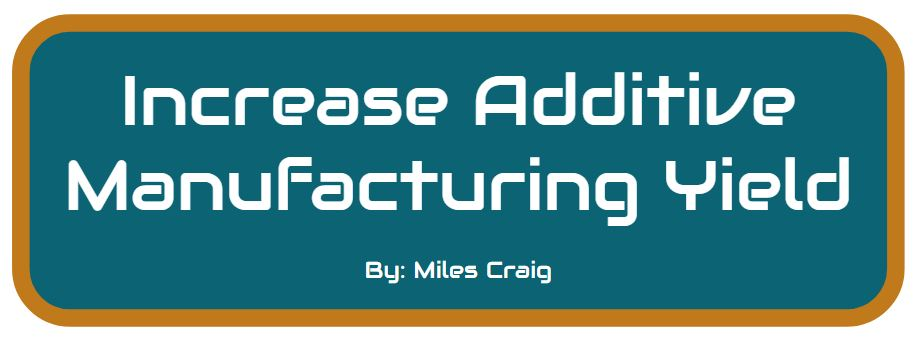

In [103]:
# Title picture
from IPython.display import Image
Image(filename='images/import/title_pic.jpg')

# Python Packages

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # for reading csv files
import glob # for reading csv files
import math # for trig on angles
import re # to search strings for nums
from functools import reduce # to combine final dfs into a single df

# Constants

In [105]:
# Constants used throughout the project

# colors use in presentation and graphs
colors = {'blue':'#0b6374', 'orange':'#c0791b', 'gray':'#666666'} 
# color picker = https://www.w3schools.com/colors/colors_picker.asp

# plot title font size
tt_fs = 20 

# the layer height(mm) for the print was held constant
layer_height = 0.03 

# convert pixels to microns     
scale_factor = 29.2 # microns per pixel normal to print surface
incident_angle = 9.1 # degrees
pix_mic_x = scale_factor / math.cos(math.radians(incident_angle))
pix_mic_y = scale_factor
pix_mic_a = pix_mic_x * pix_mic_y

# temperature thresholds (C) used to calculate melt pool metrics
mpm_thresh_temps = {'t1':1600,'t2':1800,'t3':2000,'t4':2200} 

# Print Parameters (pp)

In [106]:
# print parameters are settings used to print the part

# read print parameters (PP) file
pp = pd.read_csv('data/raw/pp/print_parameters.csv', index_col=0)

# set column type to category
pp['cond_type'] = pp['cond_type'].astype('category') 

# calculate energy densities in pp df
# LED = linear laser energy density
# GED = global energy density
# VED = volumetric laser energy density

# calculate LED
# LED = LP/SS
pp['led'] = (pp['laser_power(W)'] / pp['scan_speed(mm/s)']).round(2) 

# calculate GED
# GED = LP/(SS*HS)
pp['ged'] = (pp['laser_power(W)'] / \
    (pp['scan_speed(mm/s)'] * pp['hatch_spacing(mm)'])).round(2) 

# calculate VED
# VED = LP/(SS*HS*LH)
pp['ved'] = (pp['laser_power(W)'] / \
    (pp['scan_speed(mm/s)'] * pp['hatch_spacing(mm)'] * layer_height )).round(2) 

print('PRINT PARAMETERS')
print(pp)

PRINT PARAMETERS
           laser_power(W)  scan_speed(mm/s)  hatch_spacing(mm) cond_type  \
condition                                                                  
1                     325              1650               0.09        PV   
2                     300              1650               0.09        PV   
3                     275              1650               0.09        PV   
4                     180              1650               0.09        PV   
5                     120              1650               0.09        PV   
6                     370              3780               0.14        SV   
7                     370              3000               0.14        SV   
8                     370              2200               0.14        SV   
9                     370              1320               0.14        SV   
10                    370               880               0.14        SV   

            led   ged     ved  
condition                      
1     

# Run Log (runs)

In [107]:
# Run log is data collected about the acquisition
# of the melt pool metrics during the build

# read Run Log (runs) file
runs = pd.read_csv('data/raw/runs/runs.csv', index_col=0)
runs['date'] = pd.to_datetime(runs['date'])

# create window type column based on window size (w,h)
for i, r in runs.iterrows():
    w = r['window_w(pixels)']
    h = r['window_h(pixels)']
    
    if w==384 and h==370:
        w_type = 'full'
    elif w==384 and h==80:
        w_type = 'quart_1'
    elif w==80 and h==370:
        w_type = 'quart_2'
    runs.loc[i,'window_type'] = w_type

# set column type to category
runs['window_type'] = runs['window_type'].astype('category')    
    
# reorder runs columns
runs = runs[['date', 'condition', 'build_height(mm)', 
             'num_of_layers', 'frames_per_layer',
             'window_x(pixels)', 'window_y(pixels)',
             'window_w(pixels)', 'window_h(pixels)', 'window_type',
             'frame_rate(Hz)', 'exp_time(ms)', 'delay(ms)']]

print('RUN LOG')
print(runs.head())

RUN LOG
          date  condition  build_height(mm)  num_of_layers  frames_per_layer  \
run                                                                            
16  2018-04-24          1              0.03              1               800   
17  2018-04-24          1              0.48             20               800   
18  2018-04-24          1              2.70             20              1000   
19  2018-04-24          1              3.81             20              1000   
20  2018-04-24          2              5.19             20               800   

     window_x(pixels)  window_y(pixels)  window_w(pixels)  window_h(pixels)  \
run                                                                           
16                312               302               384               370   
17                312               302               384               370   
18                312               447               384                80   
19                464               

# Material Properties (mp)

In [108]:
# Read Material Properties (MP) file
# Material properties file containing porosity
# Technically November 14/15, 2017 data

mp = pd.read_csv('data/raw/mp/porosity.csv', index_col=0)
print('MATERIAL PROPERTIES')
print(mp)

MATERIAL PROPERTIES
           porosity(%)
condition             
1                0.039
2                0.068
3                0.067
4                1.189
5                9.860
6                8.060
7                6.225
8                1.630
9                0.115
10              -0.044


# Melt Pool Metrics (mpm)

## Read MPM Column Labels

In [109]:
# viz col labels
viz_col = list(pd.read_csv('data/raw/mpm/cols/viz_cols.csv',
                           header=None).values.T.flatten()) 

# threshold col labels
thresh_col = list(pd.read_csv('data/raw/mpm/cols/thresh_cols.csv',
                              header=None).values.T.flatten()) 

## Read MPM Tables (v,t)

In [110]:
# viz (v)
# threshold (t)
# v and t are side by side tables with identical indexes
# but different column labels for different data

# empty dictionary to read in raw mpm csv files
mpm_runs = {} 

# file path for csv files
path = r'data/raw/mpm/data' 

# list of file names to be read
all_files = glob.glob(os.path.join(path, "*.csv")) 

for f in all_files:
    
    # search for #s in file name
    run_nums = list(map(int, re.findall('\d+', f))) 
    
    if 'viz' in f:
        vt = 'v'
        col_names = viz_col
    elif 'thresh' in f:
        vt = 't'
        col_names = thresh_col
    
    # name dictionary key
    key = 'mpm_runs_%d-%d_%s' % (run_nums[1], run_nums[2], vt)
    
    # add df name to dict, read and add df as value, label columns
    mpm_runs[key] = pd.read_csv(f, names=col_names, header=None) 

print('Example viz table')
print(mpm_runs['mpm_runs_16-19_v'].head())
print('Example threshold table')
print(mpm_runs['mpm_runs_16-19_t'].head())

Example viz table
   run  frame  time(s)  exp_time(ms)  int_s_p(counts)  int_l_p(counts)  \
0   16     51    0.064      0.024957             2788             1533   
1   16     52    0.065      0.024957             2969             1579   
2   16     53    0.066      0.024957             3185             1719   
3   16     54    0.068      0.024957             3173             1783   
4   16     55    0.069      0.024957             3149             1901   

   int_s_avg_3(counts)  int_l_avg_3(counts)  int_s_avg_5(counts)  \
0               2010.1               1073.4               1335.9   
1               1989.0               1177.9               1239.7   
2               2259.8               1218.9               1390.6   
3               2288.6               1375.7               1423.5   
4               2478.2               1219.0               1446.3   

   int_l_avg_5(counts)  region_mean_short(counts)  region_mean_long(counts)  \
0               737.80                     2235.8

## Combine v & t, horizontally

In [111]:
# empty dictionary to combine mpm(v/t) dfs
mpm_temp = {} 

# run through keys of mpm_runs
for x in list(mpm_runs.keys()): 
    
    # only combine v with t, not t with v, otherwise there are duplicate dfs
    if 'v' in x: 
        v_nums = list(map(int, re.findall('\d+', x))) # search for #s in df name
        
        for y in list(mpm_runs.keys()):
            t_nums = list(map(int, re.findall('\d+', y))) # search for #s in df name
            
            if v_nums == t_nums and 't' in y:
                # name df, drop v and t notations
                combine_name = 'mpm_runs_%d-%d' % (v_nums[0], v_nums[1]) 
                
                # drop duplicate columns between v and t
                mpm_runs.get(y).drop(['run', 'frame'], axis=1, inplace=True) 
                
                # join v and t, and add to dict
                mpm_temp[combine_name] = pd.concat([mpm_runs.get(x), mpm_runs.get(y)], axis=1) 

# set mpm_runs equal to the temporary df                
mpm_runs = mpm_temp

print('Example mpm_runs table')
print(mpm_runs['mpm_runs_16-19'].head())

Example mpm_runs table
   run  frame  time(s)  exp_time(ms)  int_s_p(counts)  int_l_p(counts)  \
0   16     51    0.064      0.024957             2788             1533   
1   16     52    0.065      0.024957             2969             1579   
2   16     53    0.066      0.024957             3185             1719   
3   16     54    0.068      0.024957             3173             1783   
4   16     55    0.069      0.024957             3149             1901   

   int_s_avg_3(counts)  int_l_avg_3(counts)  int_s_avg_5(counts)  \
0               2010.1               1073.4               1335.9   
1               1989.0               1177.9               1239.7   
2               2259.8               1218.9               1390.6   
3               2288.6               1375.7               1423.5   
4               2478.2               1219.0               1446.3   

   int_l_avg_5(counts)         ...           t3_area(pixels)  t3_sat_num(-)  \
0               737.80         ...          

## Split MPM Tables per Run, Vertically

In [112]:
# empty dictionary to split dfs per run
mpm_temp = {} 

# run through keys of mpm_runs
for x in list(mpm_runs.keys()): 
    
    run_nums = list(map(int, re.findall('\d+', x))) # search for #s in file name
    run_nums = range(run_nums[0], run_nums[-1]+1) # list of #s in the range 'Runs_n-m'
    
    # run through the list of run numbers
    for y in run_nums: 
        key = 'mpm_run_%d' % (y) # name df per run
        mpm_temp[key] = mpm_runs.get(x)[mpm_runs.get(x)['run'] == y] #split df per run

# set mpm_runs equal to the temporary df        
mpm_runs = mpm_temp 

print('Example mpm_run table')
print(mpm_runs['mpm_run_16'].head())

Example mpm_run table
   run  frame  time(s)  exp_time(ms)  int_s_p(counts)  int_l_p(counts)  \
0   16     51    0.064      0.024957             2788             1533   
1   16     52    0.065      0.024957             2969             1579   
2   16     53    0.066      0.024957             3185             1719   
3   16     54    0.068      0.024957             3173             1783   
4   16     55    0.069      0.024957             3149             1901   

   int_s_avg_3(counts)  int_l_avg_3(counts)  int_s_avg_5(counts)  \
0               2010.1               1073.4               1335.9   
1               1989.0               1177.9               1239.7   
2               2259.8               1218.9               1390.6   
3               2288.6               1375.7               1423.5   
4               2478.2               1219.0               1446.3   

   int_l_avg_5(counts)         ...           t3_area(pixels)  t3_sat_num(-)  \
0               737.80         ...           

## Add Run Num and Condition Num Columns

In [113]:
# create a dict from runs df, condition vs run
cond_run = dict(zip(runs.index, runs.condition)) 

# run through keys of mpm_runs
for x in list(mpm_runs.keys()): 
    
    # search for num in df_x name
    run_num = list(map(int, re.findall('\d+', x)))[0] 
    
    # set condition number based on run number of mpm_runs df
    cond_num = cond_run[run_num] 
    
    # create a run col in mpm_runs df, fill with a constant, run number
    mpm_runs.get(x)['run'] = run_num 
    
    # create a condition col in mpm_runs df, fill with a constant, condition number
    mpm_runs.get(x)['condition'] = cond_num 
    
print('Example mpm_run table with added run num col and cond num col')
print(mpm_runs['mpm_run_16'].head())

Example mpm_run table with added run num col and cond num col
   run  frame  time(s)  exp_time(ms)  int_s_p(counts)  int_l_p(counts)  \
0   16     51    0.064      0.024957             2788             1533   
1   16     52    0.065      0.024957             2969             1579   
2   16     53    0.066      0.024957             3185             1719   
3   16     54    0.068      0.024957             3173             1783   
4   16     55    0.069      0.024957             3149             1901   

   int_s_avg_3(counts)  int_l_avg_3(counts)  int_s_avg_5(counts)  \
0               2010.1               1073.4               1335.9   
1               1989.0               1177.9               1239.7   
2               2259.8               1218.9               1390.6   
3               2288.6               1375.7               1423.5   
4               2478.2               1219.0               1446.3   

   int_l_avg_5(counts)    ...      t3_sat_num(-)  t3_sat_area(pixels)  \
0          

## Combine All MPM Tables into a Single Table

In [114]:
# combine add dfs from mpm_runs into a single df, vertically
mpm = pd.concat(mpm_runs.values(), ignore_index=True) 

# set a multi-index in mpm
mpm = mpm.set_index(['condition','run','layer','frame']) 

print('Example mpm table, a combination of all the mpm data into a single large table')
print(mpm.head())

Example mpm table, a combination of all the mpm data into a single large table
                           time(s)  exp_time(ms)  int_s_p(counts)  \
condition run layer frame                                           
1         16  1     51       0.064      0.024957             2788   
                    52       0.065      0.024957             2969   
                    53       0.066      0.024957             3185   
                    54       0.068      0.024957             3173   
                    55       0.069      0.024957             3149   

                           int_l_p(counts)  int_s_avg_3(counts)  \
condition run layer frame                                         
1         16  1     51                1533               2010.1   
                    52                1579               1989.0   
                    53                1719               2259.8   
                    54                1783               2288.6   
                    55             

# Convert MPM Columns

## Scan Direction

In [115]:
# Convert 'scan_direction(012)' into 'scan_direction(xy)'
# Update column label
# Categorize the column

# delete all rows for 0/contours, only analyze internal melt pools
mpm = mpm[mpm['scan_direction(012)'] != 0] 

# dictionary used to convert 012 into xy (x-axis, y-axis)
scan_dir_conv = {1:'x',2:'y'} 

# use scan dict to convert 012 into xy
mpm['scan_direction(012)'].replace(scan_dir_conv, inplace=True) 

# rename column with xy instead of 012
mpm.rename(columns={'scan_direction(012)':'scan_direction(xy)'}, inplace=True) 

# set column type to category
mpm['scan_direction(xy)'] = mpm['scan_direction(xy)'].astype('category') 

## Normalize Intensities

In [116]:
# Use the exposure time to normalize all intensity cols
# Update column labels

# intensity count cols
count_cols = [col for col in mpm.columns if 'counts' in col] # intensity count cols

for col in count_cols:
    # normalized intensity = intensity / exp_time, set to integer
    mpm[col] = (mpm[col] / mpm['exp_time(ms)']).astype(int) 
    
    # remane intensity columns with new units
    mpm.rename(columns={col:col.replace('counts', 'counts/ms')}, inplace=True) 

# duplicate column of constant values already in runs df    
del mpm['exp_time(ms)'] 

# update the intensity count list to include counts/ms
count_cols = [col for col in mpm.columns if 'counts' in col] 

## Linear Dimensions (Pixels - Microns)

In [117]:
# Convert linear dimensions (length, width) from pixels to microns
# Update column labels

# linear pixel cols
lin_pix_cols = [col for col in mpm.columns if ('length' in col) or ('width' in col)] 

for col in lin_pix_cols:
    
    # scale value by x scale factor
    mpm[col] = np.where(mpm['scan_direction(xy)']=='x', mpm[col] * pix_mic_x, mpm[col]) 
    
    # scale value by y scale factor
    mpm[col] = np.where(mpm['scan_direction(xy)']=='y', mpm[col] * pix_mic_y, mpm[col]) 
    
    # remane lin_pix columns
    mpm.rename(columns={col:col.replace('pixels', 'microns')}, inplace=True) 
    
    # update the lin_pix_cols list
    lin_pix_cols[lin_pix_cols.index(col)] = col.replace('pixels', 'microns')

# update the linear pixel col list to include microns
lin_pix_cols = [col for col in mpm.columns if ('length' in col) or ('width' in col)]     

## Length - Width Ratio (lw_ratio)

In [118]:
# Calculate length / width ratio in a new column (unit-less)
# Note: there are rows were the length and/or width is 0, ratio value is set to NaN
# t1_lw_ratio(-) = t1_length(microns) / t1_width(microns)

# calculate t1_lw_ratio
mpm['t1_lw_ratio(-)'] = (mpm['t1_length(microns)'] / mpm['t1_width(microns)']).round(2)

# calculate t2_lw_ratio
mpm['t2_lw_ratio(-)'] = (mpm['t2_length(microns)'] / mpm['t2_width(microns)']).round(2) 

# calculate t3_lw_ratio
mpm['t3_lw_ratio(-)'] = (mpm['t3_length(microns)'] / mpm['t3_width(microns)']).round(2) 

# calculate t4_lw_ratio
mpm['t4_lw_ratio(-)'] = (mpm['t4_length(microns)'] / mpm['t4_width(microns)']).round(2) 

## Area Dimensions (Pixels - Microns2)

In [119]:
# Convert area dimensions (area, sat_area) from pixels to microns
# Update column labels

# area pixel cols  
a_pix_cols = [col for col in mpm.columns if ('area' in col)] 

for col in a_pix_cols:
    
    # scale area by area scale factor
    mpm[col] *= pix_mic_a 
    
    # remane a_pix columns
    mpm.rename(columns={col:col.replace('pixels', 'microns2')}, inplace=True) 
    
    # update the a_pix_cols list
    a_pix_cols[a_pix_cols.index(col)] = col.replace('pixels', 'microns2') 

# update the area pixel col list to include microns2
a_pix_cols = [col for col in mpm.columns if ('area' in col)] 

## Melt Pool Locations (Pixels - Microns)

In [120]:
# Melt pool location = (loc_x, loc_y)
# Offset pixel locations per window type (if True)
# Convert pixels to microns
# Update column labels

# Currently set to "FALSE" so that the offsets and scales aren't taken into account
# When all the rows are averages per condition
# the loc_x and loc_y columns will be meaningless data
# If there was a different analysis to look at per frame data, this would be needed

# location pixel cols (loc_x, loc_y)
loc_pix_cols = [col for col in mpm.columns if ('loc' in col)] 

# if True, scale pixels to microns
loc_scale = False
# if True, offset pixels
loc_off = False

if loc_scale:
    
    for col in loc_pix_cols:
        for index, row in mpm.iterrows():
            
            # get the run from the row
            run_num = index[1] 
            # use runs df with the run_num to get the window type
            w_type = runs.at[run_num,'window_type'] 

            # use window type to align the different windows
            # these are estimated offsets
            # therfore some offsets will cause some loc_x and loc_y value to become negative
            # if True, don't offset pixels to align windows per window type
            if loc_off: 
                x_off = 0
                y_off = 0       
            elif w_type=='full':
                x_off = -20
                y_off = -20
            elif w_type=='quart_1':
                x_off = -22
                y_off = -13
            elif w_type=='quart_2':
                x_off = -5
                y_off = -24

            if 'loc_x' in col:
                mpm.at[index,'loc_x(pixels)'] = \
                (mpm.at[index,'loc_x(pixels)'] + x_off) * pix_mic_x
            elif 'loc_y' in col:
                mpm.at[index,'loc_y(pixels)'] = \
                (mpm.at[index,'loc_y(pixels)'] + y_off) * pix_mic_y
   
    # swap loc_x and loc_y cols
    # replace pixels with microns in col name
    # sensor_x_axis = printer_y_axis
    # sensor_y_axis = printer_x_axis
    mpm.rename(columns={'loc_x(pixels)':'loc_y(microns)'}, inplace=True)
    mpm.rename(columns={'loc_y(pixels)':'loc_x(microns)'}, inplace=True)

# update the location pixel col list to include microns
loc_pix_cols = [col for col in mpm.columns if ('loc' in col)] 

## Round All Dimension Columns to 2 Decimals 

In [121]:
# All dimension columns either have microns or microns2 as the units

# list all columns that have units microns or microns2
micron_cols = [col for col in mpm.columns if 'microns' in col] 

for col in micron_cols:
    mpm[col] = mpm[col].round(2) # round to 2 decimal places

## Categorize MPM Columns

In [122]:
# Reorder mpm cols by categories
# To create multi-level columns, use keys when concatinating, 
# but for now, it's not needed, use the lists instead

# general data cols
# offset and scale pixels to microns were computed above
if loc_scale: 
    mpm_gen_cols = ['time(s)','loc_x(microns)','loc_y(microns)','scan_direction(xy)']

# offset and scale pixels to microns wasn't computed above
else: 
    mpm_gen_cols = ['time(s)','loc_x(pixels)','loc_y(pixels)','scan_direction(xy)']

# intensity cols
mpm_inten_cols = ['int_s_p(counts/ms)','int_l_p(counts/ms)',
                  'int_s_avg_3(counts/ms)','int_l_avg_3(counts/ms)',
                  'int_s_avg_5(counts/ms)','int_l_avg_5(counts/ms)',
                  'region_mean_short(counts/ms)','region_mean_long(counts/ms)'] 

# peak temperature cols
mpm_peak_cols = ['temp_hybref(C)','temp_peak(C)'] 

# threshold cols
mpm_thresh_cols = [
                    't1_temp_avg(C)',
                    't1_length(microns)', 't1_width(microns)', 
                    't1_lw_ratio(-)', 't1_orient(degrees)',
                    't1_area(microns2)',
                    't1_sat_num(-)', 't1_sat_area(microns2)',
    
                    't2_temp_avg(C)',
                    't2_length(microns)', 't2_width(microns)', 
                    't2_lw_ratio(-)', 't2_orient(degrees)',
                    't2_area(microns2)',
                    't2_sat_num(-)', 't2_sat_area(microns2)',
    
                    't3_temp_avg(C)',
                    't3_length(microns)', 't3_width(microns)', 
                    't3_lw_ratio(-)', 't3_orient(degrees)',
                    't3_area(microns2)',
                    't3_sat_num(-)', 't3_sat_area(microns2)',
    
                    't4_temp_avg(C)',
                    't4_length(microns)', 't4_width(microns)', 
                    't4_lw_ratio(-)', 't4_orient(degrees)',
                    't4_area(microns2)',
                    't4_sat_num(-)', 't4_sat_area(microns2)'
                ]

# reorder mpm cols per category
mpm = pd.concat([mpm[mpm_gen_cols],
                 mpm[mpm_inten_cols],
                 mpm[mpm_peak_cols],
                 mpm[mpm_thresh_cols]],
                axis='columns')
                # to create a multilevel column df, set:
                # keys=['general','intensity','peak','threshold']

print(mpm.info())
print('--------------------------------------------------')
print(mpm.head(2))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 162284 entries, (1, 16, 1, 51) to (10, 45, 7, 5713)
Data columns (total 46 columns):
time(s)                         162284 non-null float64
loc_x(pixels)                   162284 non-null int64
loc_y(pixels)                   162284 non-null int64
scan_direction(xy)              162284 non-null category
int_s_p(counts/ms)              162284 non-null int32
int_l_p(counts/ms)              162284 non-null int32
int_s_avg_3(counts/ms)          162284 non-null int32
int_l_avg_3(counts/ms)          162284 non-null int32
int_s_avg_5(counts/ms)          162284 non-null int32
int_l_avg_5(counts/ms)          162284 non-null int32
region_mean_short(counts/ms)    162284 non-null int32
region_mean_long(counts/ms)     162284 non-null int32
temp_hybref(C)                  162284 non-null float64
temp_peak(C)                    162284 non-null float64
t1_temp_avg(C)                  162284 non-null float64
t1_length(microns)              162284 non-n

## Average MPM per Condition

In [123]:
# Average columns/metrics per rows/condition, round to 2 decimal places
mpm_avg = mpm.groupby('condition').mean().round(2) 

# Remove columns where averaging is meaningless
# technically scan direction can't be averaged by x and y
# so there is no scan_direction(xy) col
if loc_scale:
    cols_to_del = ['time(s)',
                   'loc_x(microns)','loc_y(microns)', 
                   'temp_hybref(C)',
                   't1_orient(degrees)','t2_orient(degrees)',
                   't3_orient(degrees)','t4_orient(degrees)']
else:
    cols_to_del = ['time(s)',
                   'loc_x(pixels)','loc_y(pixels)', 
                   'temp_hybref(C)',
                   't1_orient(degrees)','t2_orient(degrees)',
                   't3_orient(degrees)','t4_orient(degrees)']

# delete meaningless columns
mpm_avg = mpm_avg.drop(cols_to_del, axis=1) 

# Final DataFrames for Analysis

## Print Parameters (pp)

In [124]:
print('PRINT PARAMETERS')
print(pp.info())
print('--------------------------------------------------')
print(pp)
print('--------------------------------------------------')
print(pp.describe())

PRINT PARAMETERS
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 7 columns):
laser_power(W)       10 non-null int64
scan_speed(mm/s)     10 non-null int64
hatch_spacing(mm)    10 non-null float64
cond_type            10 non-null category
led                  10 non-null float64
ged                  10 non-null float64
ved                  10 non-null float64
dtypes: category(1), float64(4), int64(2)
memory usage: 666.0 bytes
None
--------------------------------------------------
           laser_power(W)  scan_speed(mm/s)  hatch_spacing(mm) cond_type  \
condition                                                                  
1                     325              1650               0.09        PV   
2                     300              1650               0.09        PV   
3                     275              1650               0.09        PV   
4                     180              1650               0.09        PV   
5                

## Melt Pool Metrics - Averages (mpm_avg)

In [125]:
print('MELT POOL METRICS')
print(mpm_avg.info())
print('--------------------------------------------------')
print(mpm_avg)
print('--------------------------------------------------')
print(mpm_avg.describe())

MELT POOL METRICS
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 37 columns):
int_s_p(counts/ms)              10 non-null float64
int_l_p(counts/ms)              10 non-null float64
int_s_avg_3(counts/ms)          10 non-null float64
int_l_avg_3(counts/ms)          10 non-null float64
int_s_avg_5(counts/ms)          10 non-null float64
int_l_avg_5(counts/ms)          10 non-null float64
region_mean_short(counts/ms)    10 non-null float64
region_mean_long(counts/ms)     10 non-null float64
temp_peak(C)                    10 non-null float64
t1_temp_avg(C)                  10 non-null float64
t1_length(microns)              10 non-null float64
t1_width(microns)               10 non-null float64
t1_lw_ratio(-)                  10 non-null float64
t1_area(microns2)               10 non-null float64
t1_sat_num(-)                   10 non-null float64
t1_sat_area(microns2)           10 non-null float64
t2_temp_avg(C)                  10 non-null flo

       int_s_p(counts/ms)  int_l_p(counts/ms)  int_s_avg_3(counts/ms)  \
count           10.000000           10.000000               10.000000   
mean         97265.767000        52573.699000            72792.137000   
std          32869.123704        19041.176755            28176.941563   
min          46522.530000        24027.060000            29044.970000   
25%          84082.312500        43798.212500            57484.132500   
50%         104356.780000        56958.195000            78440.400000   
75%         114467.197500        61830.210000            87502.740000   
max         154110.920000        86781.730000           123306.440000   

       int_l_avg_3(counts/ms)  int_s_avg_5(counts/ms)  int_l_avg_5(counts/ms)  \
count               10.000000               10.000000               10.000000   
mean             39634.634000            47988.743000            27190.827000   
std              16262.926111            20521.306831            12280.052993   
min              1

## Material Properties (mp)

In [126]:
print('MATERIAL PROPERTIES')
print(mp.info())
print('--------------------------------------------------')
print(mp)
print('--------------------------------------------------')
print(mp.describe())

MATERIAL PROPERTIES
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 1 columns):
porosity(%)    10 non-null float64
dtypes: float64(1)
memory usage: 160.0 bytes
None
--------------------------------------------------
           porosity(%)
condition             
1                0.039
2                0.068
3                0.067
4                1.189
5                9.860
6                8.060
7                6.225
8                1.630
9                0.115
10              -0.044
--------------------------------------------------
       porosity(%)
count    10.000000
mean      2.720900
std       3.815135
min      -0.044000
25%       0.067250
50%       0.652000
75%       5.076250
max       9.860000


## Combine (pp, mpm, mp) into a Single DF

In [127]:
# Combine pp, mpm, and mp into a single df

tables = [pp, mpm_avg, mp]

combined_df = reduce(lambda  left,right: pd.merge(left,right,on=['condition'], how='outer'), tables)
print(combined_df.head(10))

           laser_power(W)  scan_speed(mm/s)  hatch_spacing(mm) cond_type  \
condition                                                                  
1                     325              1650               0.09        PV   
2                     300              1650               0.09        PV   
3                     275              1650               0.09        PV   
4                     180              1650               0.09        PV   
5                     120              1650               0.09        PV   
6                     370              3780               0.14        SV   
7                     370              3000               0.14        SV   
8                     370              2200               0.14        SV   
9                     370              1320               0.14        SV   
10                    370               880               0.14        SV   

            led   ged     ved  int_s_p(counts/ms)  int_l_p(counts/ms)  \
condition     

# Exploratory Data Analysis (EDA)

## Print Parameter Plot

Text(2400,350,'370W')

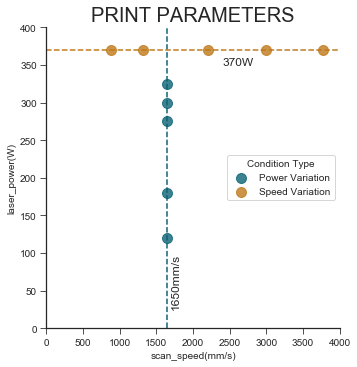

In [128]:
# Plot print parameters, comparing scan speed vs. laser power

pp_colors = {'PV':colors.get('blue'), 'SV':colors.get('orange')}

sns.set_style("ticks")

sns.lmplot('scan_speed(mm/s)', # Horizontal Axis
           'laser_power(W)', # Vertical Axis
           data=pp, # Data Source
           hue='cond_type', # Color Markers
           palette=pp_colors, # Color Dictionary
           scatter_kws={'s': 100}, # Set Marker Size
           fit_reg=False, # Don't Fix a Regression Line
           legend=False # Remove Default Legend
          )

plt.title('PRINT PARAMETERS', fontsize=tt_fs)
plt.xlim(0, 4000)
plt.ylim(0, 400)
plt.legend(['Power Variation','Speed Variation'], 
           title='Condition Type', loc='right', frameon=True)

# add vertical constant line for power with label
plt.axvline(x=1650, color=pp_colors.get('PV'), linestyle='dashed')
plt.text(1700, 90, '1650mm/s', fontsize=12, rotation=90)

# add horizontal constant line for speed with label
plt.axhline(y=370, color=pp_colors.get('SV'), linestyle='dashed')
plt.text(2400, 350, '370W', fontsize=12)

# plt.savefig('pp.jpeg', dpi=1000, bbox_inches="tight")

## Material Property Plot

(0, 10)

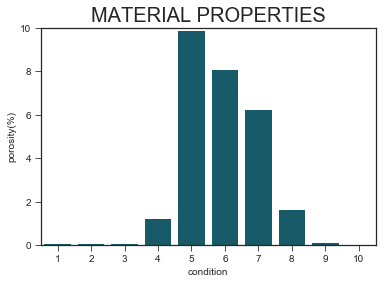

In [129]:
# Plot material properties, porosity vs. condition

sns.set_style("ticks")

ax = sns.barplot(x=mp.index, 
                 y='porosity(%)',
                 data=mp, 
                 color=colors.get('blue'))

plt.title('MATERIAL PROPERTIES', fontsize=tt_fs)
plt.ylim(0, 10)

# plt.savefig('mp.jpeg', dpi=1000, bbox_inches="tight")

## Create Dot Plot Function

In [130]:
# This function is to be reused to create dot graphs

def create_lmplot(plot_dict):

    sns.set_style("ticks")

    sns.lmplot(plot_dict['x_data'], # Horizontal Axis
               plot_dict['y_data'], # Vertical Axis
               data=plot_dict['table'], # Data Source
               hue=plot_dict['hue'], # Color Markers
               scatter_kws={'s': 100}, # Set Marker Size
               fit_reg=True, # Don't Fix a Regression Line
               legend=False # Remove Default Legend
              )
    plt.title(plot_dict['title'], fontsize=tt_fs)
    plt.xlim(plot_dict['x_lim'][0], plot_dict['x_lim'][1])
    plt.ylim(plot_dict['y_lim'][0], plot_dict['y_lim'][1])
    plt.legend(title=plot_dict['legend_title'], 
               loc='center left', 
               bbox_to_anchor=(1.0, 0., 1.0, 1.0)
              )


## Intensity Plots

### Short Intensity vs. Print Parameters

In [131]:
# Create df for short wavelength intensities vs print parameters

# select all intensity column labels for the short wavelength
int_cols_s = [x for x in list(mpm_avg) if ('(counts/ms)'and '_s_') in x]

# select the columns to be ploted on the y axis
mpm_int_s = mpm_avg[int_cols_s]

# bring the column labels into the index
mpm_int_s = mpm_int_s.stack()

# join it to the print parameters df
mpm_int_s = pp.join(mpm_int_s.to_frame())

# set index and column names
mpm_int_s.index.names = ['condition','mask']
mpm_int_s = mpm_int_s.rename(columns = {0:'intensity(counts/ms)'})

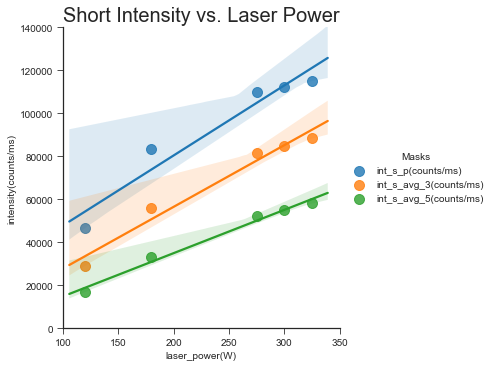

In [149]:
# Plot short intensity vs laser power

# select power variation (pv) rows
mpm_int_s_pv = mpm_int_s[mpm_int_s['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_int_s_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_int_s_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_s_pv,
                'hue' : 'mask',
                'title' : 'Short Intensity vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,140000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_s_pv)

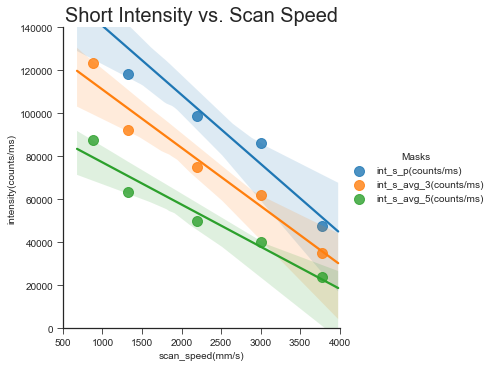

In [150]:
# Plot short intensity vs scan speed

# select speed variation (sv) rows
mpm_int_s_sv = mpm_int_s[mpm_int_s['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_int_s_sv.reset_index(level=1, inplace=True)

plot_dict_int_s_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_s_sv,
                'hue' : 'mask',
                'title' : 'Short Intensity vs. Scan Speed',
                'x_lim' : [500, 4000],
                'y_lim' : [0, 140000],
                'legend_title' : 'Masks'
             }
create_lmplot(plot_dict_int_s_sv)

### Long Intensity vs. Print Parameters

In [134]:
# Create df for long wavelength intensities vs print parameters

# select all intensity column labels for the long wavelength
int_cols_l = [x for x in list(mpm_avg) if ('(counts/ms)'and '_l_') in x]

# select the columns to be ploted on the y axis
mpm_int_l = mpm_avg[int_cols_l]

# bring the column labels into the index
mpm_int_l = mpm_int_l.stack()

# join it to the print parameters df
mpm_int_l = pp.join(mpm_int_l.to_frame())

# set index and column names
mpm_int_l.index.names = ['condition','mask']
mpm_int_l = mpm_int_l.rename(columns = {0:'intensity(counts/ms)'})

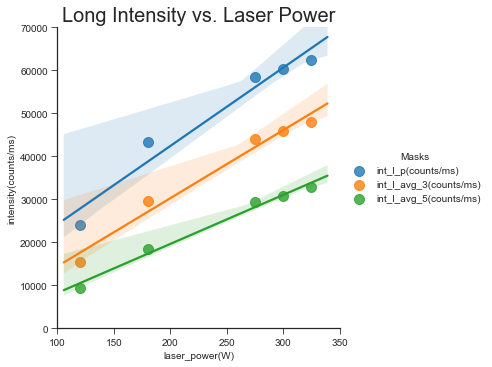

In [151]:
# Plot long intensity vs laser power

# select power variation (pv) rows
mpm_int_l_pv = mpm_int_l[mpm_int_l['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_int_l_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_int_l_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_l_pv,
                'hue' : 'mask',
                'title' : 'Long Intensity vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,70000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_l_pv)

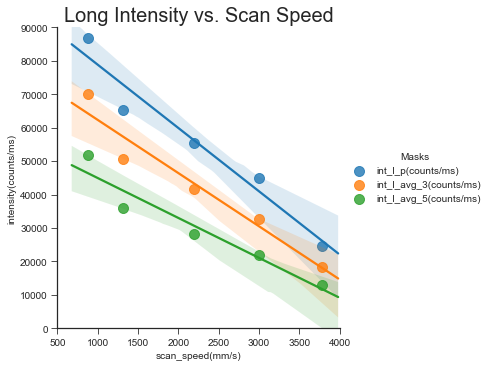

In [152]:
# Plot long intensity vs scan speed

# select speed variation (sv) rows
mpm_int_l_sv = mpm_int_l[mpm_int_l['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_int_l_sv.reset_index(level=1, inplace=True)

plot_dict_int_l_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_l_sv,
                'hue' : 'mask',
                'title' : 'Long Intensity vs. Scan Speed',
                'x_lim' : [500, 4000],
                'y_lim' : [0, 90000],
                'legend_title' : 'Masks'
             }
create_lmplot(plot_dict_int_l_sv)

## Temperature Plots

In [137]:
# Create df for temperatures vs print parameters

# select all temperature column labels
temp_cols = [x for x in list(mpm_avg) if '(C)' in x]

# select the columns to be ploted on the y axis
mpm_temp = mpm_avg[temp_cols]

# bring the column labels into the index
mpm_temp = mpm_temp.stack()

# join it to the print parameters df
mpm_temp = pp.join(mpm_temp.to_frame())

# set index and column names
mpm_temp.index.names = ['condition','threshold']
mpm_temp = mpm_temp.rename(columns = {0:'temp(C)'})

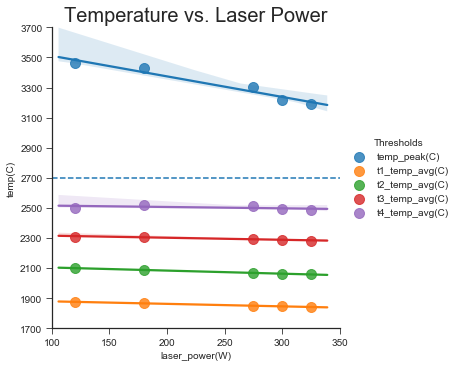

In [138]:
# Plot temperature vs laser power

# select power variation (pv) rows
mpm_temp_pv = mpm_temp[mpm_temp['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_temp_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_temp_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'temp(C)',
                'table' : mpm_temp_pv,
                'hue' : 'threshold',
                'title' : 'Temperature vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [1700,3700],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_temp_pv)

# set y tick marks
plt.yticks(range(1700, 3900, 200))

# add horizontal line for boiling point
plt.axhline(y=2700, linestyle='dashed', label='Boiling Point')

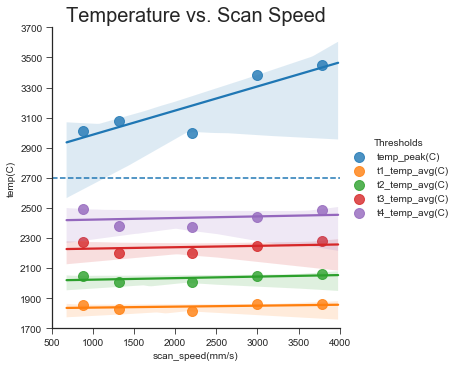

In [139]:
# Plot temperature vs scan speed

# select speed variation (sv) rows
mpm_temp_sv = mpm_temp[mpm_temp['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_temp_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_temp_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'temp(C)',
                'table' : mpm_temp_sv,
                'hue' : 'threshold',
                'title' : 'Temperature vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [1700,3700],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_temp_sv)

# set y tick marks
plt.yticks(range(1700, 3900, 200))

# add horizontal line for boiling point
plt.axhline(y=2700, linestyle='dashed', label='Boiling Point')

## Dimension Plots

### Length

In [140]:
# Create df for length vs print parameters

# select column labels
length_cols = [x for x in list(mpm_avg) if 'length' in x]

# select the columns to be ploted on the y axis
mpm_length = mpm_avg[length_cols]

# bring the column labels into the index
mpm_length = mpm_length.stack()

# join it to the print parameters df
mpm_length = pp.join(mpm_length.to_frame())

# set index and column names
mpm_length.index.names = ['condition','threshold']
mpm_length = mpm_length.rename(columns = {0:'distance(microns)'})

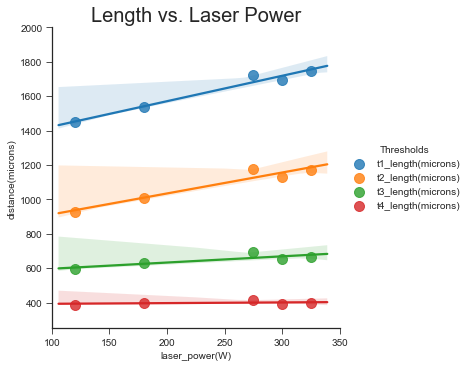

In [141]:
# Plot length vs laser power

# select power variation (pv) rows
mpm_length_pv = mpm_length[mpm_length['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_length_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_length_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'distance(microns)',
                'table' : mpm_length_pv,
                'hue' : 'threshold',
                'title' : 'Length vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [250,2000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_length_pv)

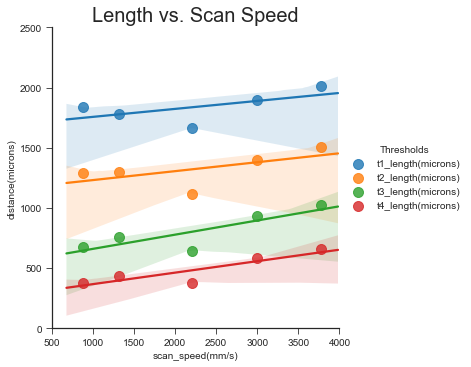

In [142]:
# Plot length vs scan speed

# select speed variation (sv) rows
mpm_length_sv = mpm_length[mpm_length['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_length_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_length_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'distance(microns)',
                'table' : mpm_length_sv,
                'hue' : 'threshold',
                'title' : 'Length vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [0,2500],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_length_sv)

### Width

In [143]:
# Create df for width vs print parameters

# select column labels
width_cols = [x for x in list(mpm_avg) if 'width' in x]

# select the columns to be ploted on the y axis
mpm_width = mpm_avg[width_cols]

# bring the column labels into the index
mpm_width = mpm_width.stack()

# join it to the print parameters df
mpm_width = pp.join(mpm_width.to_frame())

# set index and column names
mpm_width.index.names = ['condition','threshold']
mpm_width = mpm_width.rename(columns = {0:'distance(microns)'})

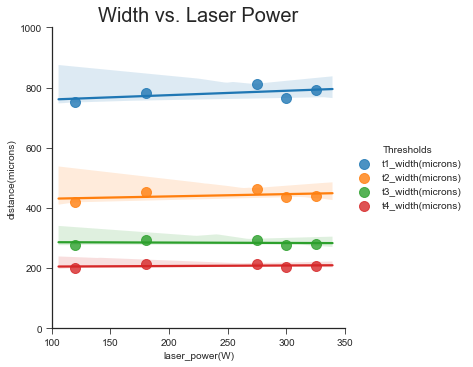

In [144]:
# Plot width vs laser power

# select power variation (pv) rows
mpm_width_pv = mpm_width[mpm_width['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_width_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_width_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'distance(microns)',
                'table' : mpm_width_pv,
                'hue' : 'threshold',
                'title' : 'Width vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,1000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_width_pv)

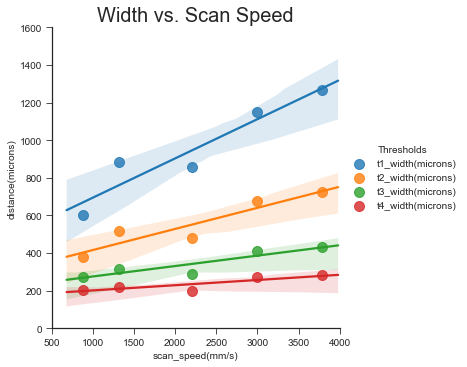

In [145]:
# Plot width vs scan speed

# select speed variation (sv) rows
mpm_width_sv = mpm_width[mpm_width['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_width_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_width_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'distance(microns)',
                'table' : mpm_width_sv,
                'hue' : 'threshold',
                'title' : 'Width vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [0,1600],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_width_sv)

### Length-Width Ratio

In [146]:
# Create df for ratio vs print parameters

# select column labels
ratio_cols = [x for x in list(mpm_avg) if 'ratio' in x]

# select the columns to be ploted on the y axis
mpm_ratio = mpm_avg[ratio_cols]

# bring the column labels into the index
mpm_ratio = mpm_ratio.stack()

# join it to the print parameters df
mpm_ratio = pp.join(mpm_ratio.to_frame())

# set index and column names
mpm_ratio.index.names = ['condition','threshold']
mpm_ratio = mpm_ratio.rename(columns = {0:'ratio(-)'})

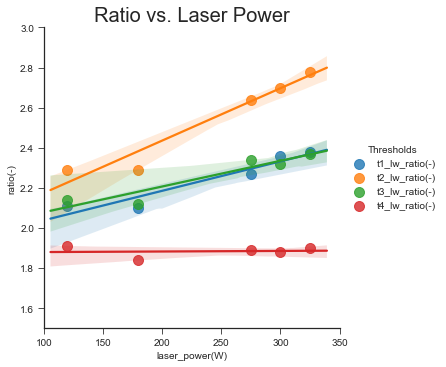

In [147]:
# Plot ratio vs laser power

# select power variation (pv) rows
mpm_ratio_pv = mpm_ratio[mpm_ratio['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_ratio_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_ratio_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'ratio(-)',
                'table' : mpm_ratio_pv,
                'hue' : 'threshold',
                'title' : 'Ratio vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [1.5,3],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_ratio_pv)

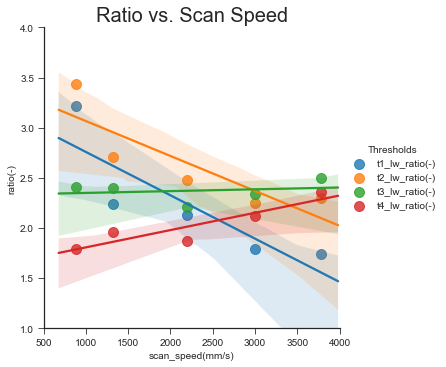

In [148]:
# Plot ratio vs scan speed

# select speed variation (sv) rows
mpm_ratio_sv = mpm_ratio[mpm_ratio['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_ratio_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_ratio_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'ratio(-)',
                'table' : mpm_ratio_sv,
                'hue' : 'threshold',
                'title' : 'Ratio vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [1,4],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_ratio_sv)